In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import sklearn
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV

import tensorflow as tf


np.random.seed(0)
tf.random.set_seed(0)

In [2]:
!git clone https://github.com/MLinApp-FP01-Team7-24/OurProject.git
%cd OurProject

Cloning into 'OurProject'...
remote: Enumerating objects: 1053, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 1053 (delta 14), reused 31 (delta 8), pack-reused 1014
Receiving objects: 100% (1053/1053), 128.88 MiB | 9.81 MiB/s, done.
Resolving deltas: 100% (215/215), done.
Updating files: 100% (108/108), done.
/content/OurProject


In [3]:
window_size = 20
k_pa = 1 # valori tra 0 e 1

In [4]:
from Models.lstm_vae.data import get_data_windows

data_train, data_cal, label_cal, data_test, label_test = get_data_windows(window_size, k_pa)

print(data_train.shape)
print(data_cal.shape, label_cal.shape)
print(data_test.shape, label_test.shape)


Reading training data...
Reading calibration data...
Reading test data...
Reading collisions data...
Normalizing data...
Getting windows for training data...
Getting windows and labels for calibration data...
Getting windows and labels for test data...
(95795, 20, 55)
(3480, 20, 55) (3480,)
(30755, 20, 55) (30755,)


In [5]:
x_dim = data_train.shape[2]
lstm_h_dim = 10
z_dim = 10

batch_size = 64
epoch_num = 10

In [6]:
from Models.lstm_vae.model import LSTM_VAE

opt = tf.keras.optimizers.Adam(epsilon=1e-6, amsgrad=True)
scheduler = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

X_train = tf.convert_to_tensor(data_train, dtype='float32')
train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True)

model = LSTM_VAE(window_size, x_dim, lstm_h_dim, z_dim, dtype='float32')
model.compile(optimizer=opt)
history = model.fit(train_dataset, epochs=epoch_num, shuffle=False, callbacks=[scheduler]).history
model.summary()
model.save_weights('./lstm_vae_ckpt')

Epoch 1/50
1496/1496 [==============================] - 34s 19ms/step - loss: 0.1996 - lr: 0.0010
Epoch 2/50
1496/1496 [==============================] - 28s 19ms/step - loss: 0.1095 - lr: 9.0000e-04
Epoch 3/50
1496/1496 [==============================] - 28s 18ms/step - loss: 0.1078 - lr: 8.1000e-04
Epoch 4/50
1496/1496 [==============================] - 29s 20ms/step - loss: 0.1073 - lr: 7.2900e-04
Epoch 5/50
1496/1496 [==============================] - 29s 19ms/step - loss: 0.1071 - lr: 6.5610e-04
Epoch 6/50
1496/1496 [==============================] - 25s 17ms/step - loss: 0.1071 - lr: 5.9049e-04
Epoch 7/50
1496/1496 [==============================] - 26s 17ms/step - loss: 0.1072 - lr: 5.3144e-04
Epoch 8/50
1496/1496 [==============================] - 27s 18ms/step - loss: 0.1073 - lr: 4.7830e-04
Epoch 9/50
1496/1496 [==============================] - 26s 17ms/step - loss: 0.1075 - lr: 4.3047e-04
Epoch 10/50
1496/1496 [==============================] - 27s 18ms/step - loss: 0.1077 

In [7]:
from google.colab import files

files.download('./lstm_vae_ckpt.data-00000-of-00001')
files.download('./lstm_vae_ckpt.index')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
score_cal = model.anomaly_score(data_cal)
label_cal = label_cal[:score_cal.shape[0]]

54/54 [==============================] - 1s 7ms/step


In [9]:
optimize = True
param_grid = {'estimator__C': np.logspace(0, 5, 6), 'estimator__gamma': np.logspace(-5, 0, 6)}

if optimize:
  cal_search = GridSearchCV(CalibratedClassifierCV(SVC(probability=True), cv=3), param_grid, cv=3, verbose=1, scoring='f1')
  cal_search.fit(score_cal, label_cal)
  cal_model = cal_search.best_estimator_
  print(cal_search.best_params_)
else:
  cal_model = CalibratedClassifierCV(SVC(probability=True, C=1, gamma=0.0001))
  cal_model.fit(score_cal, label_cal[:score_cal.shape[0]])

Fitting 3 folds for each of 36 candidates, totalling 108 fits
{'estimator__C': 10.0, 'estimator__gamma': 1e-05}


In [10]:
score_test = model.anomaly_score(data_test)
label_test = label_test[:score_test.shape[0]]

y_pred_test = cal_model.predict(score_test)
y_score_test = cal_model.predict_proba(score_test)[:, 1]

480/480 [==============================] - 5s 11ms/step


In [11]:
f1 = sklearn.metrics.f1_score(label_test, y_pred_test)
f1

0.4080635308491143

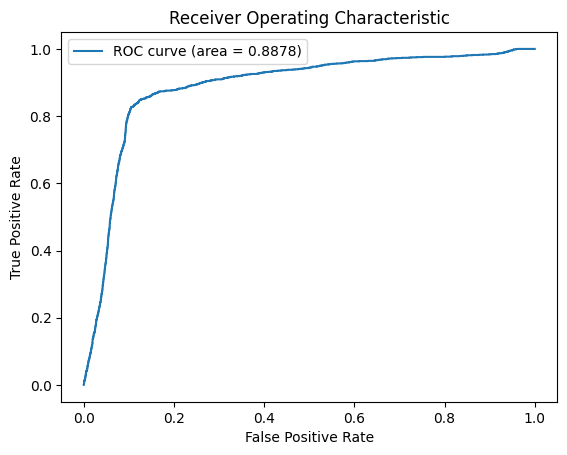

0.8878046400893777

In [12]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(label_test, y_score_test)
roc_auc = sklearn.metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

roc_auc

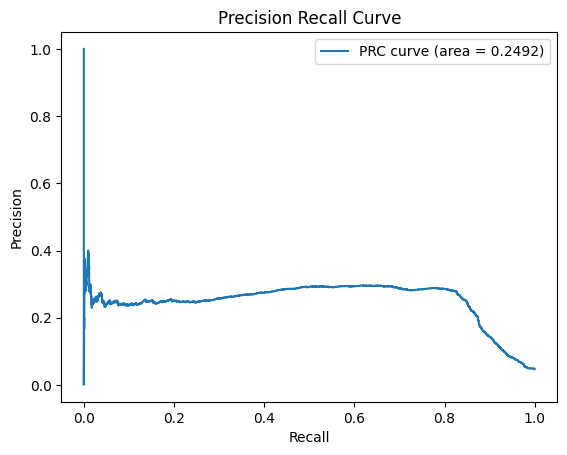

0.24917564211828486

In [13]:
precison, recall, thresholds = sklearn.metrics.precision_recall_curve(label_test, y_score_test)
prc_auc = sklearn.metrics.auc(recall, precison)

plt.plot(recall, precison, label='PRC curve (area = %0.4f)' % prc_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend()
plt.show()

prc_auc